<a href="https://colab.research.google.com/github/hyunsoo41/numerical_python/blob/main/16_bayesian_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

베이즈 통계는 조건부 확률과 비조건부확률을 연계시키는 베이즈 정리에 기반  
  
**사전 확률 분포:** 시스템에 대한 최초 지식  
**사후 확률 분포:** 관찰된 데이터에 조건화되 업데이트된 지식  
  
베이즈 정리는 사전 분포로부터 사후 분포를 계산(고차 적분 계산 필요)  
-> 사후 분포에서 표본을 추출할 수 있는 **MCMC 기법** 사용  
  
베이즈 추론 방법을 사용한 확률적 프로그래밍  
  1) 통계적 모델 생성  
  2) MCMC 방식을 통해 사후 분포의 표본 추출  
  3) 관심 성질을 계산하고 결과 추론  

In [1]:
import pymc3 as mc 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# 사전 표본 추출

In [4]:
# 고정 매개변수를 정의한 후 단일 확률 변수로 구성된 모델 생성
mu = 4.0
sigma = 2.0
model = mc.Model()

In [5]:
# 확률 변수 X 생성(tau = 정밀도)
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [6]:
model.vars  # 모델에 존재하는 확률 변수 검사

[X ~ Normal]

In [7]:
# 확률 변수로부터 표본을 추출하기 위해 MCMC 알고리즘 구현
start = dict(X=2)  # 표본 추출의 시작점 지정
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [8]:
X = trace.get_values("X")  # 추출한 표본에 접근

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability distribution')

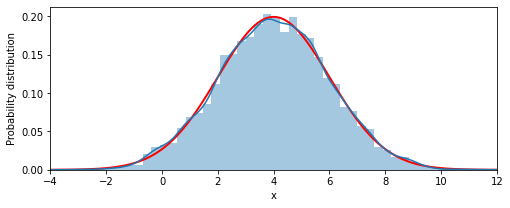

In [9]:
# 정규분포 확률 변수의 PDF(확률밀도함수)와 추출된 표본의 히스토그램 비교
x = np.linspace(-4, 12, 1000)
y = stats.norm(mu, sigma).pdf(x)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


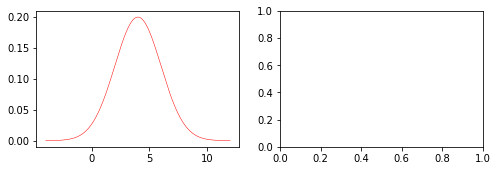

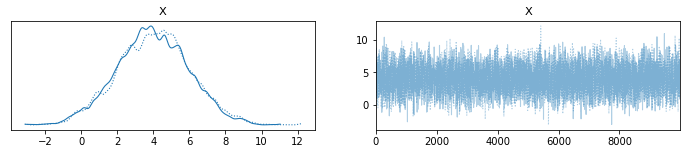

In [10]:
# 표본 추적의 KDE(커널밀도추정)과 정규 확률 분포/mcmc 표본 추출 trace 도식화
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), squeeze=False)
mc.traceplot(trace)
axes[0,0].plot(x, y, 'r', lw=0.5)

In [11]:
# 확률 변수인 매개변수 정의 후 종속 확률 변수 X 생성
model = mc.Model()
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, tau=sigma)

In [12]:
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution, X ~ Normal]

In [13]:
# mc.find_MAP 함수를 사용해 사후 분포의 최댓값 지점 추출
with model:
    start = mc.find_MAP()
start

{'mean': array(3.),
 'sigma_log__': array(-0.34657365),
 'X': array(3.),
 'sigma': array(0.70710674)}

In [14]:
# MCMC 표본 추출
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [15]:
# 변수에 대한 표본 trace를 얻어 표본 평균, 표준편차 등 통계량 계산
trace.get_values('sigma').mean()

0.780078770823973

In [16]:
X = trace.get_values('X')
X.mean()

2.891125524122078

In [17]:
trace.get_values('X').std()

2.575628423760199

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94ae6e05d0>,
      dtype=object)

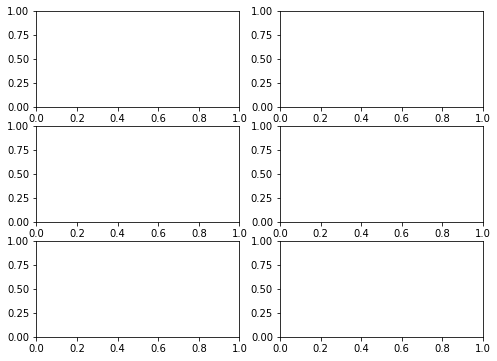

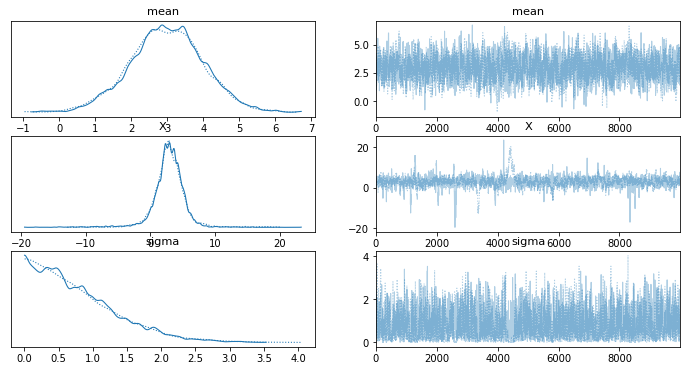

In [18]:
# 세 가지 확률 변수에 대한 KDE와 MCMC 랜덤 표본 추출 trace 도식화
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace)

# 사후 표본 추출

In [19]:
# 정규분포 확률 변수에서 표본 추출
mu = 2.5
s = 1.5
data = stats.norm(mu, s).rvs(100)

In [20]:
# 관측된 데이터를 고려해 모델을 조건화 -> observed 키워드 인수를 사용해 데이터를 추가
with mc.Model() as model:    
    mean = mc.Normal('mean', 4.0, tau=1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', tau=3.0 * np.sqrt(np.pi/2)) # true 1.5
    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data)

In [21]:
model.vars  # X를 확률 변수가 아닌 사전 분포와 연계된 우도 함수를 구성하는 확정 변수로 간주

[mean ~ Normal, sigma_log__ ~ TransformedDistribution]

In [22]:
# 모델의 사후 분포로부터 표본 추출
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [23]:
start  # 시작점은 사후 분포의 우도를 최대화하고 사전 분포의 매개변수 추정값 산출

{'mean': array(2.69917693),
 'sigma_log__': array(0.32631258),
 'sigma': array(1.38584849)}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94a7df7250>,
      dtype=object)

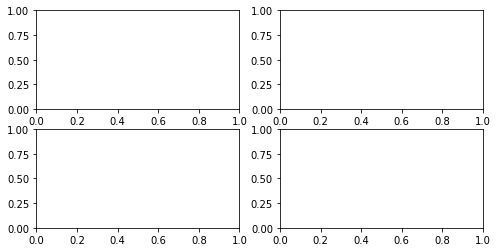

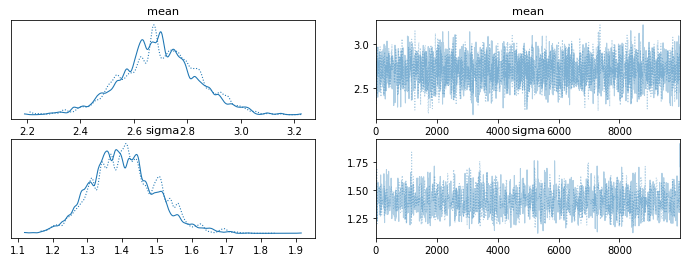

In [24]:
# mean과 signal에 대한 사후 분포 MCMC 표본 추출
# -> 사전 분포에서 추측한 값에 비해 더 참값에 가까워짐
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace)

In [25]:
mu, trace.get_values('mean').mean()

(2.5, 2.696594289988415)

In [26]:
s, trace.get_values('sigma').mean()

(1.5, 1.4064284851058848)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f94a7e52a10>],
      dtype=object)

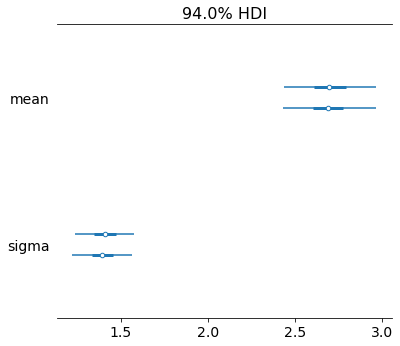

In [27]:
# mean과 sigma의 신뢰도 구간으로 시각화
mc.forestplot(trace)

In [28]:
mc.summary(trace)  # 평균, 표준편차, 사후 분위수 등 정보 확인

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,2.697,0.141,2.438,2.970,0.003,0.002,2774.0,2720.0,1.0
sigma,1.406,0.094,1.232,1.577,0.003,0.002,1403.0,1732.0,1.0


# 선형 회귀
미지의 모델 매개변수(기울기, 절편)에 사전 확률 분포를 설정하고 주어진 관측값에 따라 사후 분포 계산  
  
키와 몸무게 사이의 관계를 확인하기 위한 선형 회귀 모델

In [29]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [30]:
# 남성 대상자 중 110kg 넘는 데이터 제거
data = dataset.data[dataset.data.sex == 'M']
data = data[data.weight < 110]

In [31]:
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [32]:
# 선형 회귀 모델 정의 후 적합화
model = smf.ols("height ~ weight", data=data)
result = model.fit()

Text(0, 0.5, 'height')

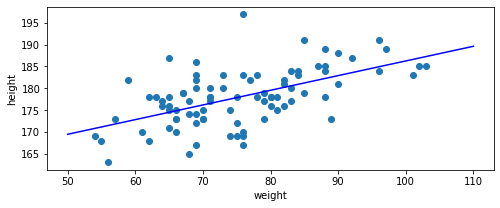

In [33]:
# 새로운 관측값에 대한 예측 수행 후 키와 몸무세 사이의 관계 도식화
x = np.linspace(50, 110, 25)
y = result.predict({"weight": x})
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")

In [34]:
# 확률 변수 생성 후 사전 분포에 할당
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    height_mu = intercept + beta * data.weight  # 키 분포의 기댓값
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)  # 확정 변수 생성
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x))  # 특정 몸무게에 해당하는 키 예측을 위한 확률 변수

In [35]:
model.vars

[sigma_interval__ ~ TransformedDistribution,
 intercept ~ Normal,
 beta ~ Normal,
 predict_height ~ Normal]

In [36]:
# 사후 분포에서 표본 추출
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step, start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 242 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94a7c6a850>,
      dtype=object)

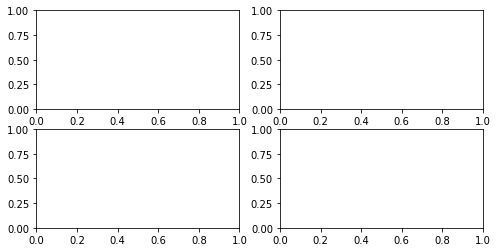

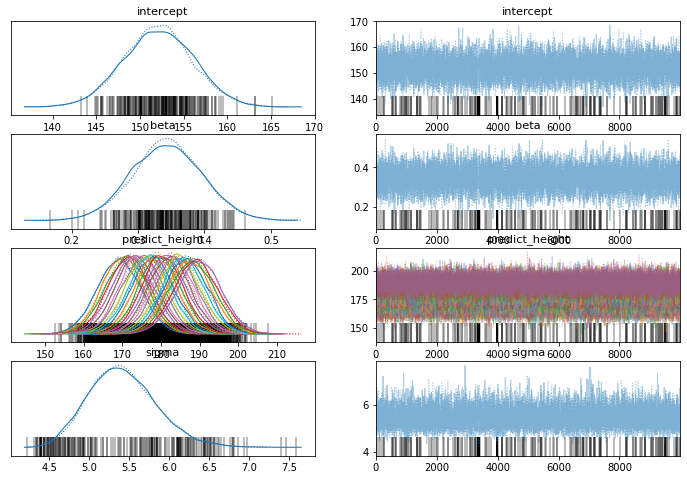

In [38]:
# 절편과 베타 계수의 분포와 표본 추출 추적
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace)

In [39]:
# statsmodel 분석 결과와 가장 일치하는 절편과 계수값은 추적 평균을 통해 구함
intercept = trace.get_values("intercept").mean()
intercept

152.08111385212504

In [40]:
beta = trace.get_values("beta").mean()
beta

0.3434679981205726

In [42]:
# statsmodel 분석 결과 
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [43]:
result.predict({"weight": 90}).values  # 90kg에 대한 키 예측

array([182.90030002])

In [44]:
# predict_height(특정 몸무게에 해당하는 키 예측을 위한 확률 변수)의 분포에 대한 평균 계산
weight_index = np.where(x == 90)[0][0]
trace.get_values("predict_height")[:, weight_index].mean()

183.01727333493622

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability distribution')

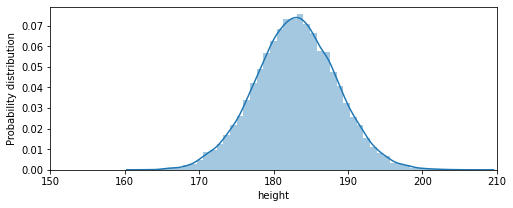

In [45]:
# 90kg에 대한 예측 키 확률 분포
fig, ax = plt.subplots(figsize=(8, 3))
sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")

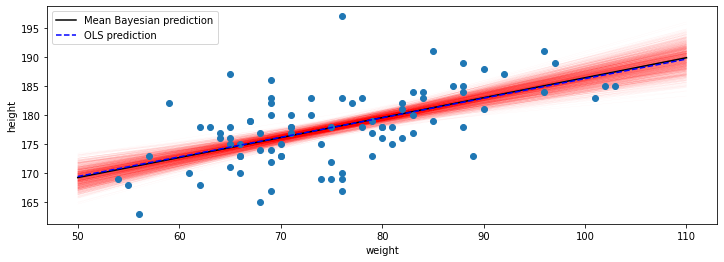

In [46]:
# 키와 몸무게의 관계를 OLS(최소 자승법) 적합화, 베이즈 모델을 통해 예측한 그래프 -> 불확실성
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)
intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)

In [47]:
# 모델, 확률변수 자동 설정 후 사후 분포로부터 표본 추출
with mc.Model() as model:
    mc.glm.GLM.from_formula('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f949fe574d0>,
      dtype=object)

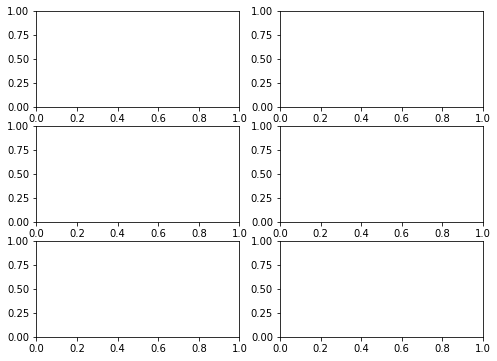

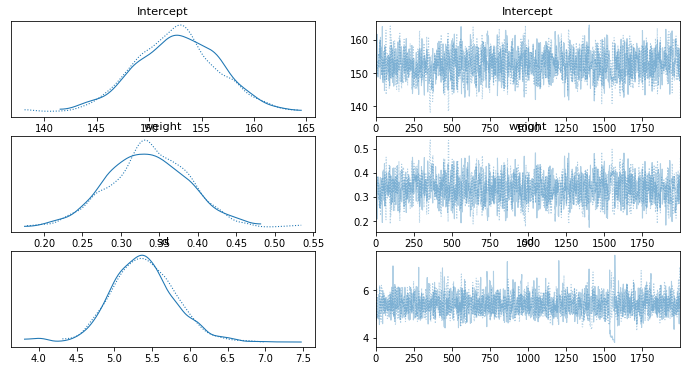

In [48]:
# GLM 모델의 표본 추적 그래프
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace)

In [49]:
# 성별을 구분해 남녀 각각 절편과 기울기를 갖는 모델
data = dataset.data.copy()
data = data[data.weight < 110]
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)  

In [50]:
# 모델 정의
with mc.Model() as model:
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight  # 인덱스 마스크를 사용해 data.weight 각 값이 올바른 레벨(남성, 여성)과 연계되도록 해야함

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [51]:
model.vars

[intercept ~ Normal, beta ~ Normal, error_interval__ ~ TransformedDistribution]

In [52]:
# 표본 추출
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9494a919d0>,
      dtype=object)

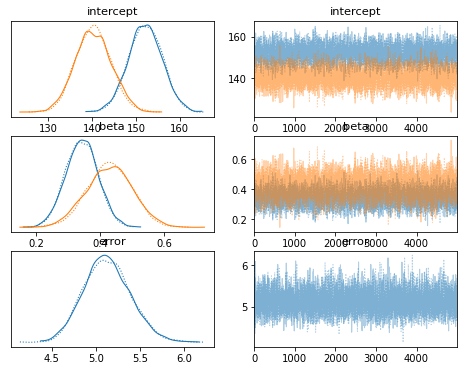

In [53]:
# 모델 매개변수의 확률 분포 KDE, 각 변수의 MCMC 표본 추출 추적(파란색: 남자, 주황색: 여자)
mc.traceplot(trace, figsize=(8, 6))

In [ ]:
# 각 성별의 절편과 기울에 대한 평균
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [ ]:
# 두 차원에 걸쳐 평균을 통해 전체 데이터셋의 절편, 기울기를 구함 -> 여성, 남성 그룹화
intercept = trace.get_values('intercept').mean()
beta = trace.get_values('beta').mean()

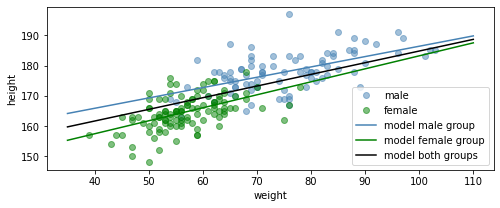

In [ ]:
# 그룹화한 결과 시각화
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
mask_m = data.sex == 0
mask_f = data.sex == 1
ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)
x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)